# Derive waterbody relative topography using Landsat

This notebook demonstrates how to load Landsat time series data, compute a water index, generate a rolling median water index composites, extract contours along the land-water boundary, and finally interpolate between contours to produce a 3D relative topographic surface. This relative topography could be easily calibrated to obtain absolute bathymetry (and accordingly, volume estimates) with a simple GPS transect from the highest to the deepest part of the lake during a dry period.

**Original Author**: Robbi Bishop-Taylor

**Original Date**: 30 October 2018

**Original Notebook**: https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/RCMRD_Demo/colombo_workshop/GA_Water_3DReservoir.ipynb

**Chunking Modifications Author**: John Rattz

**Chunking Modification Date**: 4 October 2019

In [1]:
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
import datacube
import glob
import rasterio
import scipy
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from skimage import filters
from skimage import exposure
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import time

from utils.data_cube_utilities.clean_mask import \
    landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.import_export import export_xarray_to_netcdf

from ga_utils import contour_extract
from ga_utils import contours_to_arrays
from ga_utils import interpolate_timeseries

dc = datacube.Datacube(app = 'my_app')

import os
sub_dir = 'example'
output_dir = f'output/{sub_dir}'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

no_data = -9999

%load_ext autoreload
%autoreload 2

## Set up analysis

In [2]:
# Lake Sulunga
platform = "LANDSAT_8"
product = "ls8_lasrc_tanzania" 
lat = (-5.86, -6.27)
lon = (34.97, 35.38)
# time_extents = ('2013-01-01', '2018-12-31')
time_extents = ('2016-01-01', '2016-01-31')

# Lake Balangida
# platform = "LANDSAT_8"
# product = "ls8_lasrc_tanzania" 
# lat = (-4.60, -4.76)
# lon = (35.135, 35.295)
# time_extents = ('2013-01-01', '2018-11-01')

# Lake Chala (small)
# platform = "LANDSAT_8"
# product = "ls8_lasrc_tanzania"
# lat = (-3.3282, -3.3052)
# lon = (37.6801, 37.7155)
# time_extents = ('2014-01-01', '2014-06-30')

# Lake Nakuru
# platform = "LANDSAT_8"
# product = "ls8_lasrc_kenya" 
# lat = (-0.30, -0.42) 
# lon = (36.05, 36.13)
# time_extents = ('2013-01-01', '2018-11-01')

#  Lake Volta, Ghana
# platform = "LANDSAT_8"
# product = "ls8_lasrc_ghana" 
# Full
# lat = (6.1914, 8.9334) 
# lon = (-1.4526, 0.8276)
# time_extents = ('2013-01-01', '2018-12-31')
# small subset in Eastern Region
# lat = (6.7219, 6.8092) 
# lon = (-0.6406, -0.5033)
# time_extents = ('2016-01-01', '2018-12-31')

# Lake Naivasha
# platform = "LANDSAT_8"
# product = "ls8_lasrc_kenya" 
# lat = (-0.8350, -0.6700) 
# lon = (36.2600, 36.4300)
# time_extents = ('2013-01-01', '2013-12-31')

# Lake in Singida, Tanzania
# platform = "LANDSAT_8"
# product = "ls8_usgs_sr_scene" 
# lat = (-4.665, -4.751)
# lon = (34.80, 34.885)
# time_extents = ('2013-01-01', '2018-11-01')

# Marigot de Bignone
# platform = "LANDSAT_8"
# product = "ls8_lasrc_senegal" 
# lon = (-16.43, -16.21)
# lat = (12.83, 12.65)
# time_extents = ('2013-01-01', '2018-11-01')

display_map(lat, lon)

## Obtain data for outputs

In [3]:
## Settings ##

# Contour extraction and interpolation parameters
min_vertices = 5  # This can be used to remove noise by dropping contours with less than X vertices
guassian_sigma = 0  # Controls amount of smoothing to apply to interpolated raster. Higher = smoother

# The water index to use as a proxy of water extent.
water_index = 'mndwi' # Can be any of ['mndwi', 'ndwi', 'awei']

## End Settings ##

water_index_req_bands = {'mndwi': ['green', 'swir1'],
                         'ndwi': ['green', 'nir'],
                         'awei': ['green', 'swir1','nir','swir2']}

In [4]:
def get_landsat_clean_mask_full(dataset, platform, no_data=-9999):
    """
    Returns a boolean mask denoting points in `dataset`
    which are clean according to (1) abscense of clouds according to 
    the pixel_qa band in `dataset`, (2) the `no_data` value, and 
    (3) the valid range of values for Landsat (0-10000).
    """
    cloud_mask = landsat_qa_clean_mask(dataset, platform=platform)
    no_data_mask = (dataset != no_data).to_array().all('variable')
    invalid_mask = landsat_clean_mask_invalid(dataset)
    return cloud_mask & no_data_mask & invalid_mask

In [5]:
measurements = list(set(water_index_req_bands[water_index] + ['pixel_qa'] +\
               ['red', 'green', 'blue']))
data = dc.load(latitude = lat,
               longitude = lon,
               platform = platform,
               time = time_extents,
               product = product,
               measurements = measurements,
               group_by='solar_day',
               dask_chunks={'time':5, 'latitude':500, 'longitude':500})

## Checkpointing

### Get max water extent mask

In [6]:
## Clean the data. ##
clean_mask = get_landsat_clean_mask_full(data, platform)
cleaned_data = data.where(clean_mask)

## Compute water index. ##
if water_index == 'mndwi':
    cleaned_data[water_index] = (cleaned_data.green - cleaned_data.swir1) / \
                                 (cleaned_data.green + cleaned_data.swir1)
elif water_index == 'ndwi':
    cleaned_data[water_index] = (cleaned_data.green - cleaned_data.nir) / \
                                 (cleaned_data.green + cleaned_data.nir)
else: # AWEI
    cleaned_data[water_index] = 4 * (cleaned_data.green * 0.0001 - cleaned_data.swir1 * 0.0001) - \
                                 (0.25 * cleaned_data.nir * 0.0001 + 2.75 * cleaned_data.swir2 * 0.0001)

## Obtain the max water mask. ##
max_water_mask = (cleaned_data[water_index].fillna(-1) > 0).max('time').persist()

### Get data and inundation percents for each time

In [7]:
## Compute percentages of valid data and inundation. ##
# Create mask of max extent of water (land = 0, water = 1) and set all pixels 
# outside max extent area to NaN.
water_masked = cleaned_data[water_index].where(max_water_mask)

# Calculate the valid data percentage for each time step by dividing the number of 
# non-NaN pixels in timestep by the total number of pixels in the max extent water layer
data_perc = water_masked.count(['latitude', 'longitude']) /\
            max_water_mask.sum()
cleaned_data['data_perc'] = data_perc

## Calculate inundation percent. ##
inundation_perc = (water_masked > 0).sum(['latitude', 'longitude']) \
                  / max_water_mask.sum()
cleaned_data['inundation_perc'] = inundation_perc

In [8]:
# Restrict to scenes with greater than 20% valid data and select variables for further analysis
cleaned_data = cleaned_data.sortby('inundation_perc', ascending=False)
times_to_keep = cleaned_data.data_perc > 0.2
cleaned_subset = cleaned_data.sel(time=times_to_keep)

### Obtain rolling median water composites

In [9]:
# Determine the minimum and maximum time indices for the median water composites.
min_max_indices_comp = []
for i, time_ind in enumerate(np.arange(0, len(cleaned_subset.time), 5)):
    # identify min and max index to extract rolling median
    min_index = max(time_ind - 15, 0)
    max_index = min(time_ind + 15, len(cleaned_subset.time)-1)
    min_max_indices_comp.append((min_index, max_index))
num_rolling_composites = len(min_max_indices_comp)

In [10]:
rolling_water_composites = []
time_range_strs = [] # Used to label output files.

for comp_ind, time_inds in enumerate(min_max_indices_comp):
    time_range_strs.append(
        '_'.join([np.datetime_as_string(t, unit='D') for t in 
                  cleaned_subset.time.values[list(time_inds)]]))
    
    rolling_water_composite = cleaned_subset[[water_index, 'inundation_perc']].isel(time=slice(*time_inds)).mean('time')
    
    rolling_water_composites.append(rolling_water_composite)

combined = xr.concat(rolling_water_composites, dim='time_period').sortby('time_period')

## Create visualizations

### Export time series

Interpolating 3 time-steps at 3D intervals


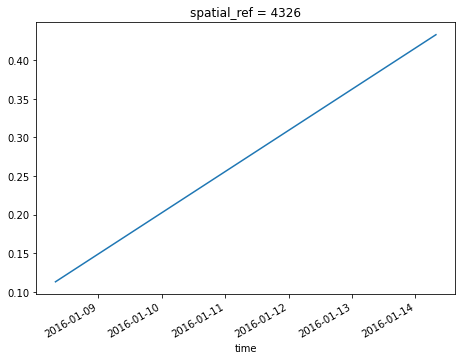

In [11]:
# Plot only observations with greater than 20% valid data
timeseries_subset = cleaned_data.inundation_perc.sel(time = times_to_keep)

# # Interpolate to one point per week, then take a rolling mean to smooth line for plotting
timeseries_subset = interpolate_timeseries(timeseries_subset.sortby('time'), freq='3D', method='linear')
timeseries_subset = timeseries_subset.rolling(time=5, min_periods=1).mean()
timeseries_subset.plot(size=5)

# Export to text file
name = 'inundation_perc'
timeseries_subset_df = timeseries_subset.to_dataframe(name=name)
timeseries_subset_df['date'] = timeseries_subset_df.index.floor('d')
timeseries_subset_df.set_index('date')
timeseries_subset_df.to_csv(output_dir + '/{}_timeseries.csv'.format(name))

### Combine the contours and plot them

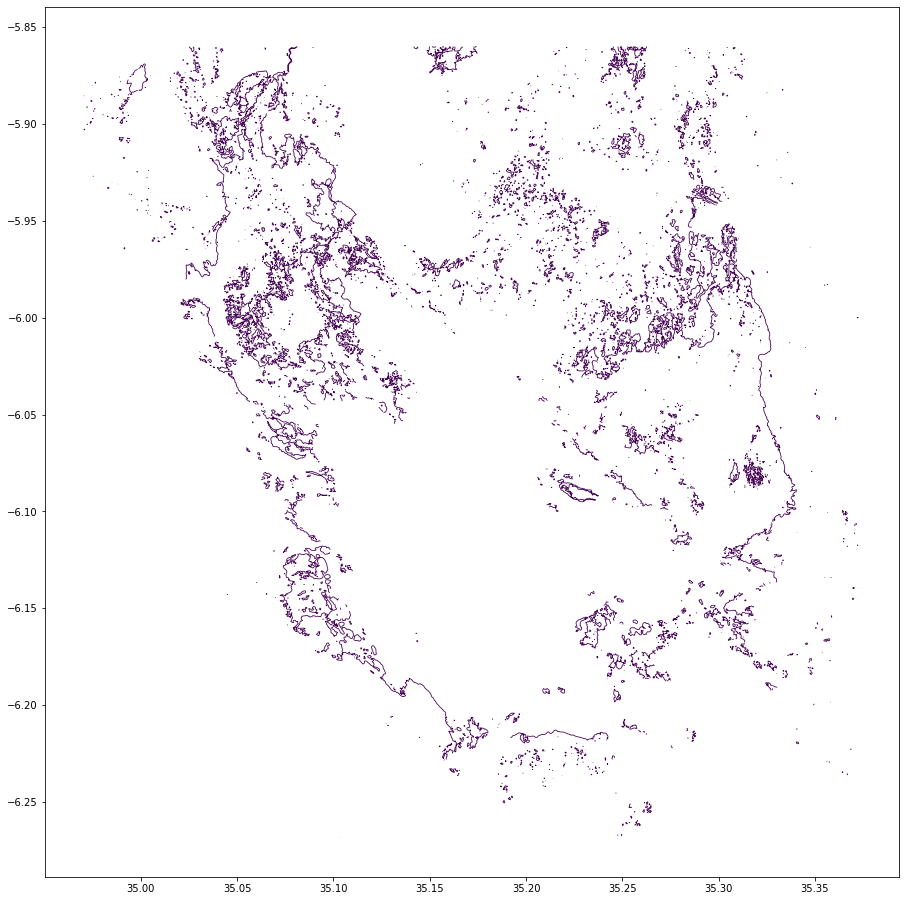

In [12]:
observations = combined.inundation_perc

for i, observation in enumerate(observations):    
    output_shp = f"{output_dir}/{name}_{time_range_strs[i]}.shp"
    if os.path.exists(output_shp):
        continue
    
    cleaned_subset_i = combined.isel(time_period=i)
    
    # Compute area
    area = float(cleaned_subset_i.inundation_perc.values) * 100 
    
    # Prepare attributes as input to contour extract
    attribute_data = {'in_perc': [area]}
    attribute_dtypes = {'in_perc': 'float'}
    
    # Set threshold
    thresh = 0 
    
    # Extract contours with custom attribute fields:
    contour_dict = contour_extract(z_values=[thresh],
                                   ds_array=cleaned_subset_i[water_index].values,
                                   ds_crs='epsg:4326',
                                   ds_affine=data.geobox.transform,
                                   output_shp=output_shp,
                                   min_vertices=min_vertices,  
                                   attribute_data=attribute_data,
                                   attribute_dtypes=attribute_dtypes)
        
# Combine all shapefiles into one file
shapefiles = glob.glob(output_dir + '/{}_*.shp'.format(name))
gdf = pd.concat([gpd.read_file(shp) for shp in shapefiles], sort=False).pipe(gpd.GeoDataFrame)

# Set CRS
gdf['crs'] = 'EPSG:4326'

# Plot contours
fig, ax = plt.subplots(figsize=(16, 16))
gdf.plot(ax=ax, column='in_perc', cmap='viridis', linewidth=0.8)
plt.show()

### Interpolate DEM values

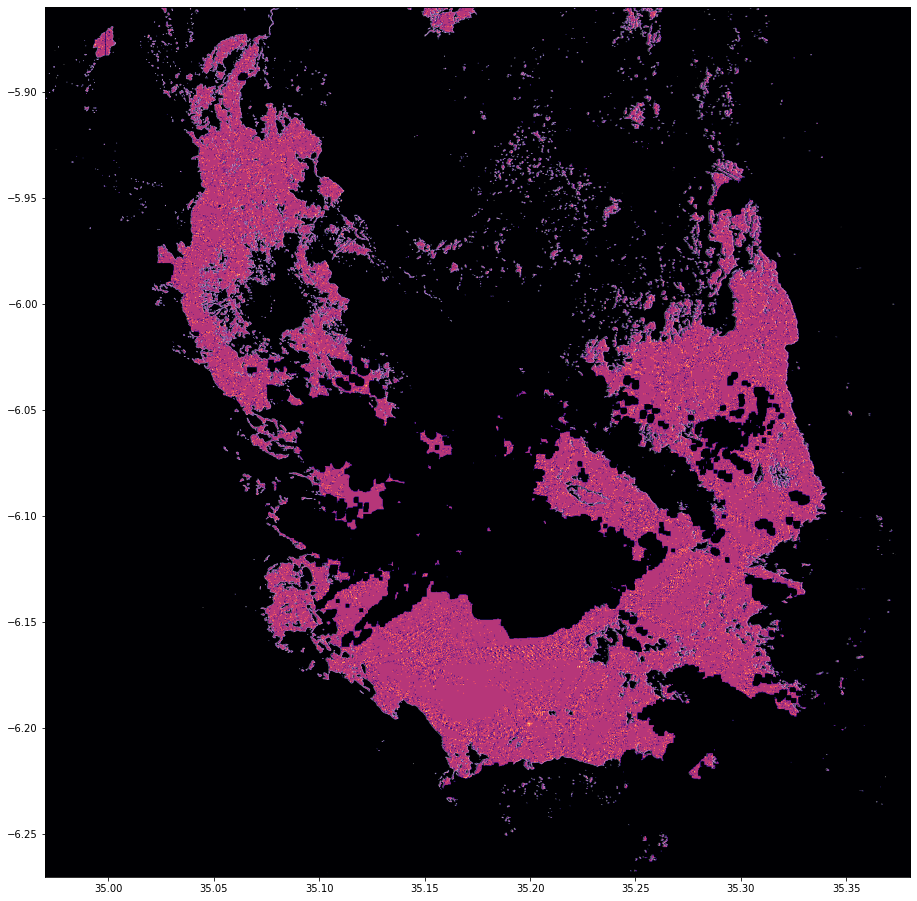

In [13]:
# Extract x, y and z points for interpolation
all_contours = contours_to_arrays(gdf=gdf, col='in_perc')
points_xy = all_contours[:, [1, 0]]
values_elev = all_contours[:, 2]

# Create grid to interpolate into
x_size, _, upleft_x, _, y_size, upleft_y = data.geobox.transform[0:6]
xcols = len(data.longitude)
yrows = len(data.latitude)
bottomright_x = upleft_x + (x_size * xcols)
bottomright_y = upleft_y + (y_size * yrows)
grid_y, grid_x = np.mgrid[upleft_y:bottomright_y:1j * yrows, upleft_x:bottomright_x:1j * xcols]

# Interpolate x, y and z values using linear/TIN interpolation
out = scipy.interpolate.griddata(points_xy, values_elev, (grid_y, grid_x), method='linear')

# Set areas outside of water composite to highest inundation percentage
test = (combined[water_index] > 0).max(dim='time_period')
out[~test] = np.nanmax(out)
out[np.isnan(out)] = np.nanmax(out)

# Apply guassian blur to smooth transitions between z values (optional)
out = filters.gaussian(out, sigma=guassian_sigma)
out = exposure.rescale_intensity(out, out_range=(timeseries_subset.min().values - 0.001, 
                                                 timeseries_subset.max().values + 0.001))

# Plot interpolated surface
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(out, cmap='magma_r', extent=[upleft_x, bottomright_x, bottomright_y, upleft_y])
gdf.plot(ax=ax, edgecolor='white', linewidth=0.5, alpha=0.5)
plt.show()

### Export DEM and RGB arrays to file

In [14]:
kwargs = {'driver': 'GTiff',
         'width': xcols,
         'height': yrows,
         'count': 1,
         'dtype': rasterio.float64,
         'crs': 'EPSG:4326',
         'transform': data.geobox.transform,
         'nodata': no_data}

with rasterio.open(output_dir + '/{}_dem.tif'.format(name), 'w', **kwargs) as target:
    target.write_band(1, out)

In [15]:
# Ensure that only one of the options below is uncommented.

# Option 1: 
#     Select nearly cloud-free images with low inundation. 
#     You may need to tune the thresholds for `data_perc` and
#     `inundation_perc`. There may be no suitable data if
#     (1) the water body does not recede much during the selected time, or
#     (2) there is too much cloud cover for the selected time.
# rgb_times = time_coords[(data.data_perc > 0.9) & (data.inundation_perc < 0.6)]
# rgb_times = cleaned_data.time.values\
#     [(cleaned_data.data_perc > 0.9).values & \
#      (cleaned_data.inundation_perc < 0.6).values]

# Option 2 (if Option 1 is untenable):
#     Get rgb values from a composite of all the data.
rgb_times = cleaned_data.time.values[[0,-1]]

# Obtain a mean composite of the RGB values.
# rgb_times = rgb_times.values[[0,-1]]

rgb_composite = \
    cleaned_data[['red', 'green', 'blue']]\
    .sel(time = rgb_times)\
    .mean('time')

In [16]:
data_array = rgb_composite.to_array().values

# Optimise colours using a percentile stretch
rgb_array = np.transpose(data_array, [1, 2, 0])
p_low, p_high = np.nanpercentile(rgb_array, [2, 98])
img_toshow = exposure.rescale_intensity(rgb_array, in_range=(p_low, p_high), out_range=(0, 1))

# Change dtype to int16 scaled between 0 and 10000 to save disk space
img_toshow = (img_toshow * 10000).astype(rasterio.int16)

kwargs = {'driver': 'GTiff',
         'width': xcols,
         'height': yrows,
         'count': 3,
         'dtype': rasterio.int16,
         'crs': 'EPSG:4326',
         'transform': data.geobox.transform,
         'nodata': no_data}

with rasterio.open(output_dir + '/{}_rgb.tif'.format(name), 'w', **kwargs) as target:
    target.write(np.transpose(img_toshow, [2, 0, 1]))